# Data Download and Pre-processing

In [1]:
from webbot import Browser
from zipfile import ZipFile
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import MinMaxScaler
global scaler
scaler = MinMaxScaler()
from sklearn.metrics import *
from IPython.core.display import HTML
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS

import sys
import os
import time
import zipfile
import datetime
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

C:\Users\Abhinav\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
def navigate(user='tiwari.abhi@husky.neu.edu', password='Ctr|hEpW'):
    global web
    web = Browser()
    web.go_to("https://freddiemac.embs.com/FLoan/secure/login.php?pagename=download2")
    web.type(user, into='email')
    web.type(password, into='password')
    web.click('Submit Credentials')
    web.click('Yes')
    web.click('Continue')

In [3]:
def get_next_quarter_str(quarter_str='Q22005'):
    try:
        quarter_int = int(quarter_str[1:2])
        
        if quarter_int <= 0:
            print('Quarter cannot be lesser than or equal to zero')
            exit(0)
        
        year = int(quarter_str[2:])
        
    except:
        print('Cannot Parse Quarter/Year to Int Value')
        exit(0)
    
    next_quarter = quarter_int + 1
    
    if next_quarter > 4:
        next_quarter = 1
        year = year + 1
    
    next_quarter_str = 'Q'+ str(next_quarter) + str(year)
    return next_quarter_str

In [4]:
def get_both_quarter_data(current_quarter,next_quarter):
    
    quarters = [current_quarter,next_quarter]
    
    global file_names
    file_names = []
    
    for q in quarters:
        web.click('historical_data1_{}.zip'.format(q))
        file_names.append('historical_data1_{}.zip'.format(q))
        time.sleep(60)
    
    global download_path
    download_path = ''
    path_list = os.getcwd().split('\\')[:3]

    for item in path_list:
        download_path = download_path + item + '\\'

    download_path = download_path + 'Downloads'

In [5]:
def assure_path_exists(path):
    if not os.path.exists(path):
        os.makedirs(path)

In [6]:
def extract_zipped_files_to_cwd(path_to_downloaded_files):
    global folder_path_all_files
    folder_path_all_files = os.getcwd() + '\\' + 'Extracted Quarterly Files'
    zip_ref = zipfile.ZipFile(path_to_downloaded_files, 'r')
    assure_path_exists(folder_path_all_files)
    zip_ref.extractall(folder_path_all_files)
    zip_ref.close()

In [7]:
def fillNAN_orig(df):
    df['fico'] = df['fico'].fillna(0)
    df['flag_fthb'] = df['flag_fthb'].fillna('X')
    df['cd_msa'] = df['cd_msa'].fillna(0)
    df['mi_pct'] = df['mi_pct'].fillna(0)
    df['cnt_units'] = df['cnt_units'].fillna(0)
    df['occpy_sts'] = df['occpy_sts'].fillna('X')
    df['cltv'] = df['cltv'].fillna(0)
    df['dti'] = df['dti'].fillna(0)
    df['ltv'] = df['ltv'].fillna(0)
    df['channel'] = df['channel'].fillna('X')
    df['ppmt_pnlty'] = df['ppmt_pnlty'].fillna('X')
    df['prop_type'] = df['prop_type'].fillna('XX')
    df['zipcode'] = df['zipcode'].fillna(0)
    df['loan_purpose'] = df['loan_purpose'].fillna('X')
    df['cnt_borr'] = df['cnt_borr'].fillna(0)
    df['flag_sc'] = df['flag_sc'].fillna('N')
    return df

In [8]:
def changedatatype_orig(df):
    # Change the data types for all column
    df[['fico', 'cd_msa', 'mi_pct', 'cnt_borr', 'cnt_units', 'cltv', 'dti', 'orig_upb', 'ltv', 'zipcode',
        'orig_loan_term']] = df[['fico', 'cd_msa', 'mi_pct', 'cnt_borr', 'cnt_units', 'cltv', 'dti', 'orig_upb', 'ltv', 'zipcode','orig_loan_term']].astype('int64')
    df[['flag_sc', 'servicer_name']] = df[['flag_sc', 'servicer_name']].astype('str')
    return df

In [9]:
def get_Origination_Quarter_File(historic_orig_files):
    writeHeader1 = True

    abc = glob.glob(historic_orig_files)
    xyz = glob.glob(folder_path_all_files + "/historical_data1_time_*.txt")
    
    #Get Rid of all the paths that point to the historical_data1_time_files
    for item in xyz:
        abc.remove(item)
    
    for f in abc:
        sample_df = pd.read_csv(f, sep="|",
                                names=['fico', 'dt_first_pi', 'flag_fthb', 'dt_matr', 'cd_msa', "mi_pct",
                                       'cnt_units', 'occpy_sts', 'cltv', 'dti', 'orig_upb', 'ltv', 'int_rt',
                                       'channel', 'ppmt_pnlty', 'prod_type', 'st', 'prop_type', 'zipcode',
                                       'id_loan', 'loan_purpose', 'orig_loan_term', 'cnt_borr', 'seller_name',
                                       'servicer_name', 'flag_sc'], skipinitialspace=True, low_memory=False)
        
        sample_df = fillNAN_orig(sample_df)
        sample_df = changedatatype_orig(sample_df)
        
        sample_df['Year'] = ['19' + x if x == '99' else '20' + x for x in (sample_df['id_loan'].apply(lambda x: x[2:4]))]
        
        #Get historical File name
        file_name = f.split('\\')[-1].split('.')[0]
        
        sample_df.to_csv(file_name + '.csv', header=True, index=False)

In [10]:
def checkAllReqColumns(df):
    cols_to_keep = ['fico','flag_fthbN','flag_fthbX','flag_fthbY','mi_pct','cnt_units','occpy_stsl','occpy_stsO','occpy_stsS','cltv','dti','orig_upb','ltv','int_rt','channelB','channelC','channelR','channelT','ppmt_pnltyN','ppmt_pnltyX','ppmt_pnltyY','prop_typeCO','prop_typeCP','prop_typeLH','prop_typeMH','prop_typePU','prop_typeSF','prop_typeXX','loan_purposeC','loan_purposeN','loan_purposeP','orig_loan_term','cnt_borr']
    
    for x in cols_to_keep:
        if not x in df.columns:
            df[x] = 0.0
            
    df = df._get_numeric_data()
    df.drop('cd_msa',axis=1,inplace=True)
    df.drop('dt_first_pi',axis=1,inplace=True)
    df.drop('dt_matr',axis=1,inplace=True)
    df.drop('flag_sc',axis=1,inplace=True)
    df.drop('zipcode',axis=1,inplace=True)
    
    return df

In [11]:
def prepare_data_for_model(df):
    dummies1 = pd.get_dummies(df['flag_fthb']).rename(columns=lambda x: 'flag_fthb' + str(x))
    train_df = pd.concat([df, dummies1], axis=1)
    
    dummies2 = pd.get_dummies(df['occpy_sts']).rename(columns=lambda x: 'occpy_sts' + str(x)) 
    train_df = pd.concat([train_df, dummies2], axis=1)
    
    dummies3 = pd.get_dummies(df['channel']).rename(columns=lambda x: 'channel' + str(x)) 
    train_df = pd.concat([train_df, dummies3], axis=1)
    
    dummies4 = pd.get_dummies(df['ppmt_pnlty']).rename(columns=lambda x: 'ppmt_pnlty' + str(x)) 
    train_df = pd.concat([train_df, dummies4], axis=1)
    
    dummies5 = pd.get_dummies(df['prop_type']).rename(columns=lambda x: 'prop_type' + str(x)) 
    train_df = pd.concat([train_df, dummies5], axis=1)
    
    dummies6 = pd.get_dummies(df['loan_purpose']).rename(columns=lambda x: 'loan_purpose' + str(x)) 
    train_df = pd.concat([train_df, dummies6], axis=1)
    
    train_df['flag_sc'] = train_df['flag_sc'].map({'Y':1,'N':0})
    
    train_df = checkAllReqColumns(train_df)
    
    return train_df

In [12]:
def train_linear_model(current_year_df,next_year_df):
    global lm
    
    scaled_curr_df = scaler.fit_transform(current_year_df)
    scaled_next_df = scaler.fit_transform(next_year_df)
    
    df_current = pd.DataFrame(scaled_curr_df,columns=current_year_df.columns)
    df_next = pd.DataFrame(scaled_next_df,columns=next_year_df.columns)
    
    X_train = df_current.drop('int_rt', axis=1)
    y_train = df_current['int_rt']
    X_test = df_next.drop('int_rt', axis=1)
    y_test = df_next['int_rt']

    lm = LinearRegression()
    
    lm.fit(X_train,y_train)
    
    reg_pred_train = lm.predict(X_train)
    reg_pred_test = lm.predict(X_test)
    
    print('-Training Metrics-')
    compute_metrics(lm,reg_pred_train,y_train)
    print('-Testing Metrics-')
    compute_metrics(lm,reg_pred_test,y_test)

In [13]:
def train_rf_model(current_year_df,next_year_df):
    global rf
    
    scaled_curr_df = scaler.fit_transform(current_year_df)
    scaled_next_df = scaler.fit_transform(next_year_df)
    
    df_current = pd.DataFrame(scaled_curr_df,columns=current_year_df.columns)
    df_next = pd.DataFrame(scaled_next_df,columns=next_year_df.columns)
    
    X_train = df_current.drop('int_rt', axis=1)
    y_train = df_current['int_rt']
    X_test = df_next.drop('int_rt', axis=1)
    y_test = df_next['int_rt']

    rf = RandomForestRegressor()
    
    rf.fit(X_train,y_train)
    
    rf_pred_train = rf.predict(X_train)
    rf_pred_test = rf.predict(X_test)
    
    print('-Training Metrics-')
    compute_metrics(rf,rf_pred_train,y_train)
    print('-Testing Metrics-')
    compute_metrics(rf,rf_pred_test,y_test)

In [14]:
def train_nn_model(current_year_df,next_year_df):
    global nn
    
    scaled_curr_df = scaler.fit_transform(current_year_df)
    scaled_next_df = scaler.fit_transform(next_year_df)
    
    df_current = pd.DataFrame(scaled_curr_df,columns=current_year_df.columns)
    df_next = pd.DataFrame(scaled_next_df,columns=next_year_df.columns)
        
    X_train = df_current.drop('int_rt', axis=1)
    y_train = df_current['int_rt']
    X_test = df_next.drop('int_rt', axis=1)
    y_test = df_next['int_rt']

    nn = MLPRegressor()
    
    nn.fit(X_train,y_train)
    
    nn_pred_train = nn.predict(X_train)
    nn_pred_test = nn.predict(X_test)
    
    print('-Training Metrics-')
    compute_metrics(nn,nn_pred_train,y_train)
    print('-Testing Metrics-')
    compute_metrics(nn,nn_pred_test,y_test)

In [15]:
def compute_metrics(model,predicted_val,true_val):
    RSq = r2_score(true_val,predicted_val)
    print('R Squared: ' + str(RSq))
    MAE = mean_absolute_error(true_val,predicted_val)
    print('MAE: ' + str(MAE))
    RMS = np.sqrt(mean_squared_error(true_val,predicted_val))
    print('RMS: ' + str(RMS))
    MAPE = np.mean(np.abs((true_val - predicted_val) / true_val)) * 100
    print('MAPE: ' + str(MAPE))
    print('\n')

In [16]:
def fwd_selection(model,processed_curr_df,processed_next_df):
    global sfs_fwd
    sfs_fwd = SFS(model, k_features = 25, forward=True, scoring='neg_mean_squared_error', n_jobs=-1)
    
    #Feature Selection on Current Quarter Data
    sfs_fwd = sfs_fwd.fit(processed_curr_df.drop('int_rt',axis=1),processed_curr_df['int_rt'])
    
    fig1 = plot_sfs(sfs_fwd.get_metric_dict(), kind='std_dev')

    plt.ylim([0.8, 1])
    plt.title('Sequential Forward Selection (w. StdDev)')
    plt.grid()
    plt.show()
    
    print('----Selected Features from FWD Search----')
    print(sfs_fwd.k_feature_names_)
    
    X_train_sfs = sfs_fwd.transform(processed_curr_df.drop('int_rt',axis=1))
    X_test_sfs = sfs_fwd.transform(processed_next_df.drop('int_rt',axis=1))
    
    y_train_sfs = processed_curr_df['int_rt']
    y_test_sfs = processed_next_df['int_rt']
    
    model.fit(X_train_sfs,y_train_sfs)
    
    fwd_pred_train = model.predict(X_train_sfs)
    fwd_pred_test = model.predict(X_test_sfs)
    
    print('-Training Metrics-')
    compute_metrics(model,fwd_pred_train,y_train_sfs)
    print('-Testing Metrics-')
    compute_metrics(model,fwd_pred_test,y_test_sfs)

In [17]:
def bwd_selection(model,processed_curr_df,processed_next_df):
    global sfs_bwd
    sfs_bwd = SFS(model, k_features = 30, forward=False, scoring='neg_mean_squared_error', n_jobs=-1)
    
    #Feature Selection on Current Quarter Data
    sfs_bwd = sfs_bwd.fit(processed_curr_df.drop('int_rt',axis=1).values,processed_curr_df['int_rt'].values)
    
    fig1 = plot_sfs(sfs_bwd.get_metric_dict(), kind='std_dev')

    plt.ylim([0.8, 1])
    plt.title('Sequential Backward Selection (w. StdDev)')
    plt.grid()
    plt.show()
    
    print('----Selected Features from BWD Search----')
    indxs = list(sfs_bwd.k_feature_names_)
    str_cols = processed_curr_df.columns
    features = set(zip(indxs,str_cols))
    print(features)
    
    X_train_sfs = sfs_bwd.transform(processed_curr_df.drop('int_rt',axis=1))
    X_test_sfs = sfs_bwd.transform(processed_next_df.drop('int_rt',axis=1))
    
    y_train_sfs = processed_curr_df['int_rt']
    y_test_sfs = processed_next_df['int_rt']
    
    model.fit(X_train_sfs,y_train_sfs.values)
    
    bwd_pred_train = model.predict(X_train_sfs)
    bwd_pred_test = model.predict(X_test_sfs)
    
    print('-Training Metrics-')
    compute_metrics(model,bwd_pred_train,y_train_sfs)
    print('-Testing Metrics-')
    compute_metrics(model,bwd_pred_test,y_test_sfs)

In [18]:
def exh_selection(model,processed_curr_df,processed_next_df):
    global efs_exh
    efs_exh = EFS(model, min_features=10, max_features=12, scoring='neg_mean_squared_error', n_jobs=-1)
    
    #Feature Selection on Current Quarter Data
    efs_exh = efs_exh.fit(processed_curr_df.drop('int_rt',axis=1),processed_curr_df['int_rt'])
    
    print('----Selected Features from Exhaustive Search----')
    print(efs_exh.k_feature_names_)
    
    X_train_efs = efs_exh.transform(processed_curr_df.drop('int_rt',axis=1))
    X_test_efs = efs_exh.transform(processed_next_df.drop('int_rt',axis=1))
    
    y_train_efs = processed_curr_df['int_rt']
    y_test_efs = processed_next_df['int_rt']
    
    model.fit(X_train_efs,y_train_efs)
    
    exh_pred_train = model.predict(X_train_efs)
    exh_pred_test = model.predict(X_test_sfs)
    
    print('-Training Metrics-')
    compute_metrics(model,exh_pred_train,y_train_sfs)
    print('-Testing Metrics-')
    compute_metrics(model,exh_pred_test,y_test_sfs)

In [19]:
def FinancialCrisisEconomicBoomCheck(current_year_df,next_year_df):
    global rf_FcEb
    X_train = current_year_df.drop('int_rt', axis=1)
    y_train = current_year_df['int_rt']
    X_test = next_year_df.drop('int_rt', axis=1)
    y_test = next_year_df['int_rt']

    rf = RandomForestRegressor()
    
    rf.fit(X_train,y_train)
    
    rf_pred_train = rf.predict(X_train)
    rf_pred_test = rf.predict(X_test)
    
    print('-Training Metrics-')
    compute_metrics(rf,rf_pred_train,y_train)
    print('-Testing Metrics-')
    compute_metrics(rf,rf_pred_test,y_test)

In [20]:
def main():
    global current_quarter,current_qtr_df,next_qtr_df,processed_curr_df,processed_next_df

#     #navigate(user, password)
#     current_quarter = input('Input the Quarter as QNYYYY: ')
#     user = input('Enter the Email ID: ')
#     password = input('Enter the Password: ')
    
#     validate_input(current_quarter,user,password)
    
    navigate()
    
    current_quarter = 'Q12005'
        
    next_quarter = get_next_quarter_str(current_quarter)
    
    if int(next_quarter[2:]) not in list(range(2005,2017)):
        print("The Quarters requested are out of range")
        exit(0)
    
    get_both_quarter_data(current_quarter,next_quarter)
    
    for file in file_names:
        extract_zipped_files_to_cwd(download_path + '\\' + file)
    
    get_Origination_Quarter_File(folder_path_all_files + "/historical_data1_*.txt")
    
    current_qtr_df = pd.read_csv(file_names[0].split('.')[0] + '.csv',low_memory=False)
    next_qtr_df = pd.read_csv(file_names[1].split('.')[0] + '.csv',low_memory=False)
    
    processed_curr_df = prepare_data_for_model(current_qtr_df)
    processed_next_df = prepare_data_for_model(next_qtr_df)
    
    #Training all 3 Models on all features
    print('--------Metrics for Quarters {} & {} when all features included--------'.format(current_quarter,next_quarter))
    print('--Linear Model--')
    train_linear_model(processed_curr_df,processed_next_df)
    print('--Random Forrest Model--')
    train_rf_model(processed_curr_df,processed_next_df)
    print('--Neural Network Model--')
    train_nn_model(processed_curr_df,processed_next_df)
    
    #Training all 3 Models using Forward Selection
    print('--------Metrics for Quarters {} & {} using Step Wise Forward Selection--------'.format(current_quarter,next_quarter))
    print('--Linear Model--')
    fwd_selection(lm,processed_curr_df,processed_next_df)

    
    #Training all 3 Models using Backward Selection
    print('--------Metrics for Quarters {} & {} using Step Wise Backward Selection--------'.format(current_quarter,next_quarter))
    print('--Linear Model--')
    bwd_selection(lm,processed_curr_df,processed_next_df)

    
#     #Training all 3 Models using Exhaustive Selection
#     print('--------Metrics for Quarters {} & {} using Exhaustive Selection--------'.format(current_quarter,next_quarter))
#     print('--Linear Model--')
#     exh_selection(lm,processed_curr_df,processed_next_df)
#     print('--Random Forrest Model--')
#     exh_selection(rf,processed_curr_df,processed_next_df)
#     print('--Neural Network Model--')
#     exh_selection(nn,processed_curr_df,processed_next_df)

--------Metrics for Quarters Q12005 & Q22005 when all features included--------
--Linear Model--
-Training Metrics-
R Squared: 0.37824332551294526
MAE: 0.03117975927906556
RMS: 0.042333727542449164
MAPE: inf


-Testing Metrics-
R Squared: -7.552125114340646
MAE: 0.1668793633297866
RMS: 0.17451317400554442
MAPE: inf


--Random Forrest Model--
-Training Metrics-
R Squared: 0.8874993586832409
MAE: 0.012709767571167013
RMS: 0.0180075148433962
MAPE: inf


-Testing Metrics-
R Squared: -6.248111710769709
MAE: 0.1514119410909852
RMS: 0.16065847256185653
MAPE: inf


--Neural Network Model--
-Training Metrics-
R Squared: 0.4194995134306374
MAE: 0.030312908659880303
RMS: 0.04090511108414472
MAPE: inf


-Testing Metrics-
R Squared: -7.55718501730712
MAE: 0.16718333618521852
RMS: 0.17456479212051698
MAPE: inf


--------Metrics for Quarters Q12005 & Q22005 using Step Wise Forward Selection--------
--Linear Model--


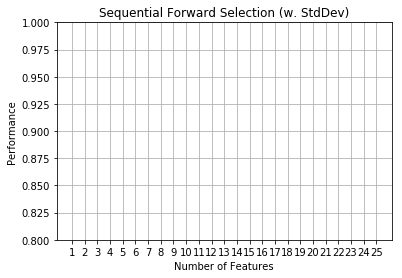

----Selected Features from FWD Search----
('fico', 'mi_pct', 'cnt_units', 'orig_upb', 'ltv', 'orig_loan_term', 'cnt_borr', 'Year', 'flag_fthbN', 'flag_fthbY', 'occpy_stsI', 'occpy_stsP', 'occpy_stsS', 'channelT', 'ppmt_pnltyN', 'prop_typeCO', 'prop_typeCP', 'prop_typeMH', 'loan_purposeC', 'loan_purposeN', 'loan_purposeP', 'flag_fthbX', 'occpy_stsl', 'occpy_stsO', 'prop_typeLH')
-Training Metrics-
R Squared: 0.37578469953954297
MAE: 0.2137363480849155
RMS: 0.2905588170295989
MAPE: 3.781493586814121


-Testing Metrics-
R Squared: 0.1387088493410591
MAE: 0.2477951753046037
RMS: 0.3253674158239672
MAPE: 4.22543964475919


--------Metrics for Quarters Q12005 & Q22005 using Step Wise Backward Selection--------
--Linear Model--


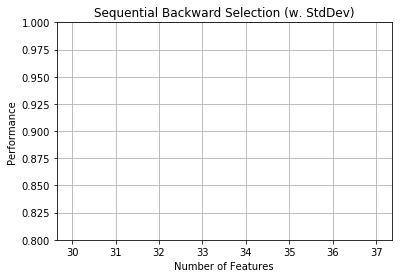

----Selected Features from BWD Search----
{('18', 'occpy_stsP'), ('34', 'prop_typeMH'), ('9', 'int_rt'), ('24', 'channelT'), ('2', 'cnt_units'), ('1', 'mi_pct'), ('14', 'flag_fthb9'), ('21', 'channelC'), ('16', 'flag_fthbY'), ('7', 'orig_upb'), ('13', 'Year'), ('33', 'prop_typeCP'), ('29', 'ppmt_pnltyY'), ('22', 'channelR'), ('31', 'prop_type99'), ('15', 'flag_fthbN'), ('25', 'ppmt_pnltyN'), ('19', 'occpy_stsS'), ('36', 'prop_typeSF'), ('20', 'channelB'), ('8', 'ltv'), ('32', 'prop_typeCO'), ('6', 'dti'), ('12', 'cnt_borr'), ('0', 'fico'), ('5', 'cltv'), ('10', 'orig_loan_term'), ('35', 'prop_typePU'), ('17', 'occpy_stsI'), ('26', 'ppmt_pnltyX')}
-Training Metrics-
R Squared: 0.3778787159275897
MAE: 0.21371984314934345
RMS: 0.29007104778433945
MAPE: 3.781508563465947


-Testing Metrics-
R Squared: 0.14062073419563847
MAE: 0.2478800878028751
RMS: 0.3250060916474583
MAPE: 4.227709284455065




In [21]:
main()

In [33]:
#Features that were common to both FWD and BWD search
list_of_features = ['fico','mi_pct','cnt_units','orig_upb','ltv','orig_loan_term','cnt_borr','Year','flag_fthbN',
                   'flag_fthbY','occpy_stsI','occpy_stsP','occpy_stsS','channelT','ppmt_pnltyN','prop_typeCO',
                   'prop_typeCP','prop_typeMH','int_rt']

# Predicting Using the Best Model from TPOT

In [50]:
from sklearn.svm import LinearSVR
svr = LinearSVR(C=0.01, dual=True, epsilon=0.01, loss="squared_epsilon_insensitive", tol=1e-05)
svr.fit(processed_curr_df[list_of_features].drop('int_rt',axis=1),processed_curr_df['int_rt'])

LinearSVR(C=0.01, dual=True, epsilon=0.01, fit_intercept=True,
     intercept_scaling=1.0, loss='squared_epsilon_insensitive',
     max_iter=1000, random_state=None, tol=1e-05, verbose=0)

In [52]:
predicted = svr.predict(processed_next_df[list_of_features].drop('int_rt',axis=1))

In [53]:
compute_metrics(svr,predicted,processed_next_df['int_rt'])

R Squared: 0.07995490223480839
MAE: 0.2548131319729696
RMS: 0.33628200125854696
MAPE: 4.352770076691688


